In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append('../src/')
import dataset_prep
from dataset_prep import *
from models import *

from tensorflow import keras
from keras import layers, applications, utils, models, optimizers, Input, callbacks
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Chemin du dossier contenant tous les .csv
data_folder = '../data'

### Création des csv avec les nouvelles features

Nécessite les csv suivants : 
 - `merged1.csv`  (DoS - 13)
 - `merged2.csv`   (DoS Random - 14)
 - `merged3.csv`   (DoS Disruptive - 15)
 - `merged4.csv`   (Dos Random Sybil - 18)
 - `merged5.csv`   (Dos Disruptive Sybil - 19)

In [7]:
def new_features(merged):
    
    print(merged.shape)
    
    sender = []
    max_speed1 = []
    max_speed2 = []
    nb_packets_sent = []


    for i in range(len(merged['sender'].unique())):
        print(i)
        sender.append(merged['sender'].unique()[i])
        max_speed1.append(merged[merged['sender'] == merged['sender'].unique()[i]]['spd_x_send'].max())
        max_speed2.append(merged[merged['sender'] == merged['sender'].unique()[i]]['spd_y_send'].max())
        nb_packets_sent.append(len(merged[merged['sender'] == merged['sender'].unique()[i]]))

    senders = pd.DataFrame()
    senders['sender'] = sender
    senders['max_speed1'] = max_speed1
    senders['max_speed2'] = max_speed2
    senders['nb_packets_sent'] = nb_packets_sent
    
    merged = merged.merge(senders, on='sender')
    
    merged['frequency1'] = abs(merged['spd_x_send'] - merged['max_speed1']/2)
    merged['frequency2'] = abs(merged['spd_y_send'] - merged['max_speed2']/2)
    
    merged = merged.sort_values(by=['sender', 'receiver', 'sendTime'])
    merged['time_diff'] = merged.groupby(['sender', 'receiver'])['sendTime'].diff()
    
    merged['distRealSR1'] = merged['pos_x_rec'] - merged['pos_x_send']
    merged['distRealSR2'] = merged['pos_y_rec'] - merged['pos_y_send']
    merged['diffSpdSR1'] = merged['spd_x_rec'] - merged['spd_x_send']
    merged['diffSpdSR2'] = merged['spd_y_rec'] - merged['spd_y_send']
    merged['diffAclSR1'] = merged['acl_x_rec'] - merged['acl_x_send']
    merged['diffAclSR2'] = merged['acl_y_rec'] - merged['acl_y_send']
    merged['diffHedSR1'] = merged['hed_x_rec'] - merged['hed_x_send']
    merged['diffHedSR2'] = merged['hed_y_rec'] - merged['hed_y_send']

    merged['deltaPosRec1'] = abs(merged['pos_x_rec'] - merged['pos_x_rec_f'])
    merged['deltaPosRec2'] = abs(merged['pos_y_rec'] - merged['pos_y_rec_f'])
    merged['deltaSpdRec1'] = abs(merged['spd_x_rec'] - merged['spd_x_rec_f'])
    merged['deltaSpdRec2'] = abs(merged['spd_y_rec'] - merged['spd_y_rec_f'])
    merged['deltaAclRec1'] = abs(merged['acl_x_rec'] - merged['acl_x_rec_f'])
    merged['deltaAclRec2'] = abs(merged['acl_y_rec'] - merged['acl_y_rec_f'])
    merged['deltaHedRec1'] = abs(merged['hed_x_rec'] - merged['hed_x_rec_f'])
    merged['deltaHedRec2'] = abs(merged['hed_y_rec'] - merged['hed_y_rec_f'])

    merged['deltaPos1'] = abs(merged['pos_x_send'] - merged['pos_x_send_f'])
    merged['deltaPos2'] = abs(merged['pos_y_send'] - merged['pos_y_send_f'])
    merged['deltaSpd1'] = abs(merged['spd_x_send'] - merged['spd_x_send_f'])
    merged['deltaSpd2'] = abs(merged['spd_y_send'] - merged['spd_y_send_f'])
    merged['deltaAcl1'] = abs(merged['acl_x_send'] - merged['acl_x_send_f'])
    merged['deltaAcl2'] = abs(merged['acl_y_send'] - merged['acl_y_send_f'])
    merged['deltaHed1'] = abs(merged['hed_x_send'] - merged['hed_x_send_f'])
    merged['deltaHed2'] = abs(merged['hed_y_send'] - merged['hed_y_send_f'])

    merged['distance'] = np.sqrt(merged['distRealSR1']**2 + merged['distRealSR2']**2)
    merged['difSpeed'] = np.sqrt(merged['diffSpdSR1']**2 + merged['diffSpdSR2']**2)
    merged['estAoA'] = np.arctan(merged['distRealSR2']/merged['distRealSR1'])
    
    
    return(merged)

In [4]:
# DoS - 13
df_dos_random = pd.read_csv(data_folder + '/merged1.csv')
# Create a new csv file with new features from merged2.csv
new_features(df_dos_random).to_csv(os.path.join(data_folder + '', 'DoS_0709_new_columns.csv'), index=False)

KeyboardInterrupt: 

In [4]:
# DoS Random  - 14
df_dos_random = pd.read_csv(data_folder + '/merged2.csv')
# Create a new csv file with new features from merged2.csv
new_features(df_dos_random).to_csv(os.path.join(data_folder + '', 'DoS_Random_0709_new_columns.csv'), index=False)

(4679311, 51)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196


KeyboardInterrupt: 

In [2]:
# DoS Disruptive - 15

df_dos_disruptive = pd.read_csv(data_folder + '/merged3.csv')

new_features(df_dos_disruptive).to_csv(os.path.join(data_folder + '', 'DoS_Disruptive_0709_new_columns.csv'), index=False)

In [9]:
# TODO vérifier le csv merged4.csv parce qu'il y a des labels 19 alors que ça devrait être 18
# DoS Random Sybil - 18
df_dos_random_sybil = pd.read_csv(data_folder + '/merged4.csv')

new_features(df_dos_random_sybil).to_csv(os.path.join(data_folder + '', 'DoS_Random_Sybil_0709_new_columns.csv'), index=False)

(3822887, 51)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273


In [7]:
# DoS Disruptive Sybil - 19
df_dos_disruptive_sybil = pd.read_csv(data_folder + '/merged5.csv')

new_features(df_dos_disruptive_sybil).to_csv(os.path.join(data_folder + '', 'DoS_Disruptive_Sybil_0709_new_columns.csv'), index=False)

(3822887, 51)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273


In [26]:
# Vérifiaction des labels
df_dos_random_sybil.labelRec.value_counts

<bound method IndexOpsMixin.value_counts of 0           0
1           0
2          19
3           0
4           0
           ..
3822882     0
3822883     0
3822884     0
3822885    19
3822886    19
Name: labelRec, Length: 3822887, dtype: int64>

## DataFrame selection

Import de la base de données

In [3]:
# Colonnes choisies - label, sender & sendTime obligatoires
# selected_columns = [
# "nb_packets_sent",
# "distance",
# "distRealSR1",
# "pos_y_rec_f",
# "pos_y_rec",
# "pos_x_rec_f",
# "pos_x_rec",
# "pos_x_send",
# "pos_y_send",
# "spd_x_send",
# "spd_y_send",
# "sendTime",
# "receiver",
# "sender",
# "label"
# ]
selected_columns = [
"distance",
"pos_x_send",
"pos_y_send",
"spd_x_send",
"spd_y_send",
"sendTime",
"sender",
"label"
]

input_sequence_shape = len(selected_columns)-2 # On drop label et sender dans la création de séquences

data_type = {
    "label":"int8",
    "sender":"int16",
    "receiver":"int16",
    "nb_packets_sent":"int16"
    
}

In [12]:
# DoS (13)
df = dataset_prep.import_dataset(data_folder + '/DoS_0709_new_columns.csv', selected_columns, data_type)

Nombre de lignes avant nettoyage :  4753433
Nombre de lignes après nettoyage :  4753433


In [4]:
# DoS Random (14)
df = dataset_prep.import_dataset(data_folder + '/DoS_Random_0709_new_columns.csv', selected_columns, data_type)

Nombre de lignes avant nettoyage :  4679311
Nombre de lignes après nettoyage :  4679311


In [4]:
# DoS Disruptive (15)
df = dataset_prep.import_dataset(data_folder + '/DoS_Disruptive_0709_new_columns.csv', selected_columns)

Nombre de lignes avant nettoyage :  4667151
Nombre de lignes après nettoyage :  4667151


In [10]:
# DoS Random Sybil (18)
df = dataset_prep.import_dataset(data_folder + '/DoS_Random_Sybil_0709_new_columns.csv', selected_columns)

Nombre de lignes avant nettoyage :  3822887
Nombre de lignes après nettoyage :  3822887


In [ ]:
# DoS Disruptive Sybil (19)
df = dataset_prep.import_dataset(data_folder + '/DoS_Disruptive_Sybil_0709_new_columns.csv', selected_columns)

In [5]:
df.label.value_counts()

15    2585806
0     2081345
Name: label, dtype: int64

In [ ]:
df.info(verbose=True, memory_usage='deep', show_counts=True)

# Initialisation des données

In [9]:
# Séparation en données d'entrainement et de test
X_train, X_test, y_train, y_test = data_preparation(df, sample=False)

Nombre de séquences :  460425
X_train :  (414382, 20, 6)
y_train :  (414382,)
X_test :  (46043, 20, 6)
y_test :  (46043,)


# Modèles

## Modèle dense simple

In [53]:
simple_model = dense_network()

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#opt = keras.optimizers.SGD(learning_rate=0.01)
simple_model.compile(loss='binary_crossentropy', optimizer="adam", metrics='accuracy')

In [56]:
history = simple_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.3, callbacks=[callback])

Epoch 1/20


2023-02-01 13:51:11.533153: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 66915680 exceeds 10% of free system memory.


500/503 [============================>.] - ETA: 0s - loss: 8.5787 - accuracy: 0.4438

2023-02-01 13:51:18.343339: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28679040 exceeds 10% of free system memory.


503/503 [==============================] - 8s 14ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435
Epoch 2/20
503/503 [==============================] - 8s 15ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435
Epoch 3/20
503/503 [==============================] - 8s 16ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435
Epoch 4/20
503/503 [==============================] - 7s 13ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435
Epoch 5/20
503/503 [==============================] - 7s 13ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435
Epoch 6/20
503/503 [==============================] - 7s 13ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435


<AxesSubplot:>

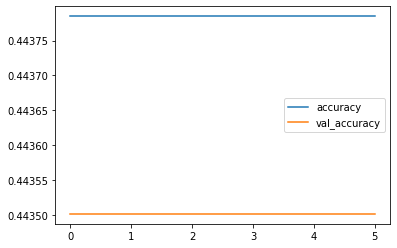

In [26]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

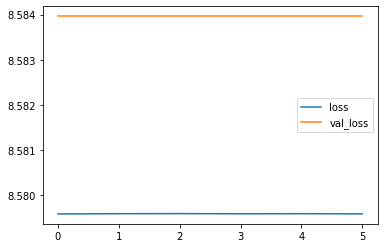

In [27]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [ ]:
y_pred=simple_model.predict(X_test)


In [29]:
eval=simple_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 1s 3ms/step - loss: 8.7198 - accuracy: 0.4347


[8.719759941101074, 0.4346974790096283]

## RNN

In [30]:
#2 stacked RNN
rnn_model = stacked_RNN()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [31]:
history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.3, callbacks=[callback])

Epoch 1/20


2023-02-01 14:02:22.859087: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 66915680 exceeds 10% of free system memory.


498/503 [============================>.] - ETA: 0s - loss: 0.4202 - accuracy: 0.8221

2023-02-01 14:02:28.860898: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28679040 exceeds 10% of free system memory.


503/503 [==============================] - 7s 11ms/step - loss: 0.4198 - accuracy: 0.8221 - val_loss: 0.3501 - val_accuracy: 0.8445
Epoch 2/20
503/503 [==============================] - 5s 11ms/step - loss: 0.3368 - accuracy: 0.8514 - val_loss: 0.8098 - val_accuracy: 0.6363
Epoch 3/20
503/503 [==============================] - 6s 11ms/step - loss: 0.3346 - accuracy: 0.8521 - val_loss: 0.3379 - val_accuracy: 0.8465
Epoch 4/20
503/503 [==============================] - 5s 11ms/step - loss: 0.3296 - accuracy: 0.8526 - val_loss: 0.4370 - val_accuracy: 0.7911
Epoch 5/20
503/503 [==============================] - 5s 11ms/step - loss: 0.3272 - accuracy: 0.8531 - val_loss: 0.3326 - val_accuracy: 0.8497
Epoch 6/20
503/503 [==============================] - 6s 11ms/step - loss: 0.3259 - accuracy: 0.8545 - val_loss: 0.3301 - val_accuracy: 0.8478
Epoch 7/20
503/503 [==============================] - 6s 11ms/step - loss: 0.3239 - accuracy: 0.8565 - val_loss: 0.3863 - val_accuracy: 0.8265
Epoch 8/20

<AxesSubplot:>

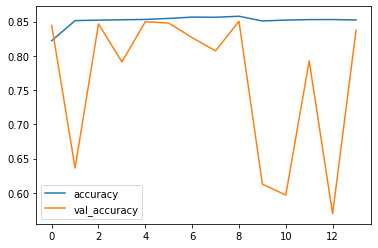

In [32]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

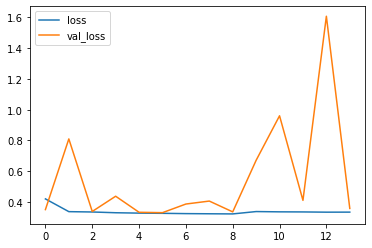

In [33]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [34]:
y_pred=rnn_model.predict(X_test)
y_pred

array([[0.0814237 ],
       [0.25599977],
       [0.99995077],
       ...,
       [0.11677942],
       [0.6047377 ],
       [0.9872718 ]], dtype=float32)

In [35]:
# arrondir les prédictions avant de les evalués
y_pred = [0 if x < 0.5 else 1 for x in y_pred] 
y_pred
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83      4440
         1.0       0.89      0.83      0.86      5774

    accuracy                           0.85     10214
   macro avg       0.85      0.85      0.85     10214
weighted avg       0.85      0.85      0.85     10214



In [36]:
eval=rnn_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 1s 3ms/step - loss: 0.3330 - accuracy: 0.8488


[0.332971453666687, 0.8488349318504333]

## Test LSTM

In [119]:
lstm_model = stacked_LSTM_small(input_sequence_shape)

In [121]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.01)
lstm_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')

In [ ]:
lstm_model.summary()

In [123]:
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.3, callbacks=[callback])

Epoch 1/20
394/394 [==============================] - 27s 51ms/step - loss: 0.6845 - accuracy: 0.5667 - val_loss: 0.6855 - val_accuracy: 0.5652
Epoch 2/20
394/394 [==============================] - 18s 46ms/step - loss: 0.6847 - accuracy: 0.5671 - val_loss: 0.6848 - val_accuracy: 0.5652
Epoch 3/20
394/394 [==============================] - 17s 43ms/step - loss: 0.6847 - accuracy: 0.5671 - val_loss: 0.6848 - val_accuracy: 0.5652
Epoch 4/20
394/394 [==============================] - 17s 43ms/step - loss: 0.6847 - accuracy: 0.5671 - val_loss: 0.6848 - val_accuracy: 0.5652
Epoch 5/20
394/394 [==============================] - 17s 43ms/step - loss: 0.6844 - accuracy: 0.5671 - val_loss: 0.6846 - val_accuracy: 0.5652
Epoch 6/20
394/394 [==============================] - 18s 46ms/step - loss: 0.6845 - accuracy: 0.5671 - val_loss: 0.6846 - val_accuracy: 0.5652


<AxesSubplot: >

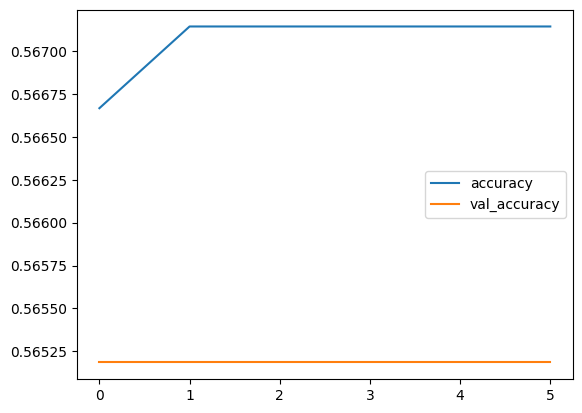

In [124]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot: >

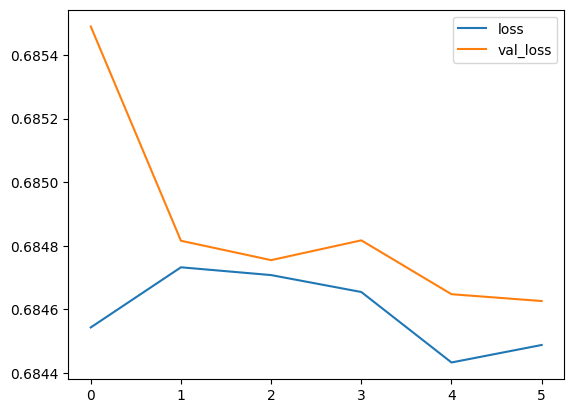

In [125]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [119]:
y_pred=lstm_model.predict(X_test)
y_pred

array([[0.54696834],
       [0.54696834],
       [0.54696834],
       ...,
       [0.54696834],
       [0.54696834],
       [0.54696834]], dtype=float32)

In [120]:
eval=lstm_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 3s 9ms/step - loss: 0.6846 - accuracy: 0.5653


[0.6846228241920471, 0.5653025507926941]

## Mélange SimpleRNN et LSTM

In [126]:
lstm_rnn_model = mix_rnn_lstm()

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.01)
lstm_rnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')

In [127]:
history = lstm_rnn_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.3, callbacks=[callback])

Epoch 1/25
394/394 [==============================] - 58s 137ms/step - loss: 0.5769 - accuracy: 0.6630 - val_loss: 2909.3411 - val_accuracy: 0.5652
Epoch 2/25
394/394 [==============================] - 17s 43ms/step - loss: 0.4208 - accuracy: 0.7880 - val_loss: 4.5898 - val_accuracy: 0.5652
Epoch 3/25
394/394 [==============================] - 18s 47ms/step - loss: 0.3692 - accuracy: 0.8277 - val_loss: 2.1021 - val_accuracy: 0.5650
Epoch 4/25
394/394 [==============================] - 20s 52ms/step - loss: 0.3320 - accuracy: 0.8589 - val_loss: 101.0154 - val_accuracy: 0.5652
Epoch 5/25
394/394 [==============================] - 19s 48ms/step - loss: 0.2869 - accuracy: 0.8816 - val_loss: 37.9704 - val_accuracy: 0.4348
Epoch 6/25
394/394 [==============================] - 19s 48ms/step - loss: 0.2521 - accuracy: 0.8998 - val_loss: 15.6581 - val_accuracy: 0.5652
Epoch 7/25
394/394 [==============================] - 16s 42ms/step - loss: 0.2346 - accuracy: 0.9095 - val_loss: 7.4290 - val_a

<AxesSubplot: >

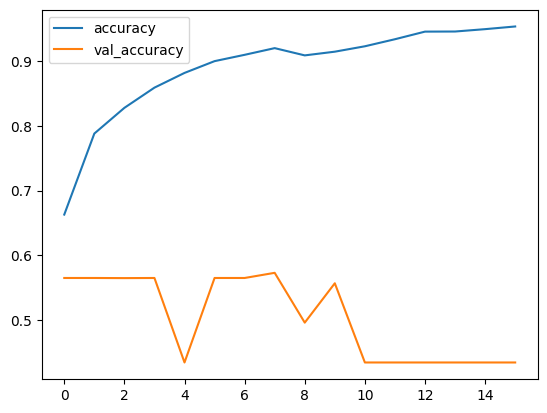

In [129]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot: >

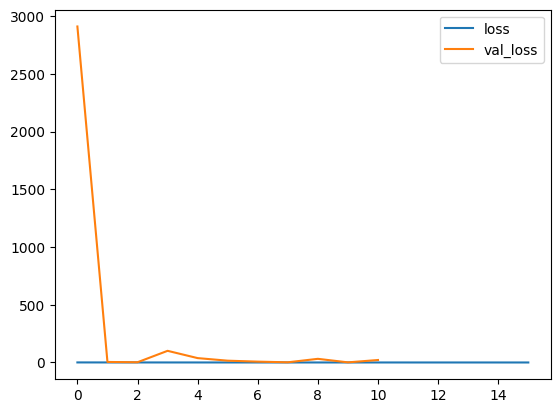

In [130]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [131]:
y_pred=lstm_rnn_model.predict(X_test)
y_pred

63/63 [==============================] - 2s 16ms/step


array([[0.9998226 ],
       [0.9999999 ],
       [0.99991626],
       ...,
       [0.9995111 ],
       [0.9235139 ],
       [0.9999978 ]], dtype=float32)

In [132]:
eval=lstm_rnn_model.evaluate(X_test, y_test)
eval

63/63 [==============================] - 1s 23ms/step - loss: 1.6335 - accuracy: 0.5675


[1.6334964036941528, 0.5674999952316284]

63/63 [==============================] - 2s 29ms/step - loss: 1.6335 - accuracy: 0.5675
Evaluation du modèle : [1.6334964036941528, 0.5674999952316284]
63/63 [==============================] - 1s 15ms/step


Text(45.722222222222214, 0.5, 'True Labels')

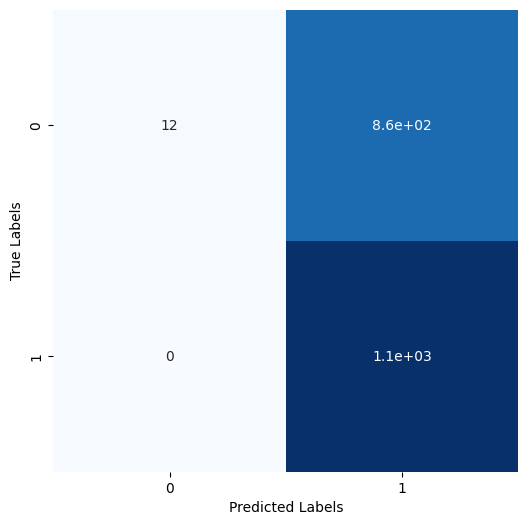

In [133]:
print(f"Evaluation du modèle : {lstm_rnn_model.evaluate(X_test, y_test)}")
y_pred = lstm_rnn_model.predict(X_test)
preds = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, preds, normalize='all')
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

## Stacked GRU (3 stacked)

In [53]:
stacked_GRU_model = stacked_GRU()

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.01)
stacked_GRU_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')

In [55]:
history = stacked_GRU_model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.3, callbacks=[callback])

Epoch 1/25
985/985 [==============================] - 115s 111ms/step - loss: 0.3738 - accuracy: 0.8373 - val_loss: 0.9403 - val_accuracy: 0.5868
Epoch 2/25
985/985 [==============================] - 106s 108ms/step - loss: 0.3593 - accuracy: 0.8390 - val_loss: 0.5020 - val_accuracy: 0.7611
Epoch 3/25
985/985 [==============================] - 116s 117ms/step - loss: 0.3476 - accuracy: 0.8449 - val_loss: 0.7107 - val_accuracy: 0.6635
Epoch 4/25
985/985 [==============================] - 126s 128ms/step - loss: 0.3462 - accuracy: 0.8443 - val_loss: 0.5011 - val_accuracy: 0.7790
Epoch 5/25
985/985 [==============================] - 116s 118ms/step - loss: 0.3433 - accuracy: 0.8449 - val_loss: 0.6469 - val_accuracy: 0.6301
Epoch 6/25
985/985 [==============================] - 122s 124ms/step - loss: 0.3457 - accuracy: 0.8437 - val_loss: 0.4450 - val_accuracy: 0.7931
Epoch 7/25
985/985 [==============================] - 124s 126ms/step - loss: 0.3380 - accuracy: 0.8479 - val_loss: 0.4416 -

<AxesSubplot: >

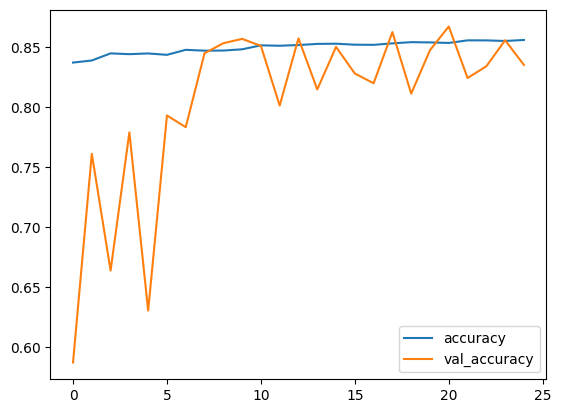

In [56]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot: >

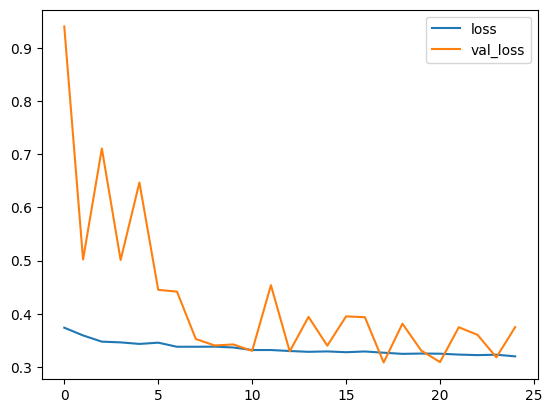

In [57]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [58]:
y_pred=stacked_GRU_model.predict(X_test)
y_pred

313/313 [==============================] - 9s 26ms/step


array([[0.9470375 ],
       [0.21045142],
       [0.99951273],
       ...,
       [0.53367186],
       [0.16180539],
       [0.16153032]], dtype=float32)

In [59]:
eval=stacked_GRU_model.evaluate(X_test, y_test)
eval

313/313 [==============================] - 6s 20ms/step - loss: 0.3846 - accuracy: 0.8338


[0.38455015420913696, 0.8338000178337097]

313/313 [==============================] - 6s 21ms/step - loss: 0.3846 - accuracy: 0.8338
Evaluation du modèle : [0.38455015420913696, 0.8338000178337097]
313/313 [==============================] - 6s 20ms/step


Text(45.722222222222214, 0.5, 'True Labels')

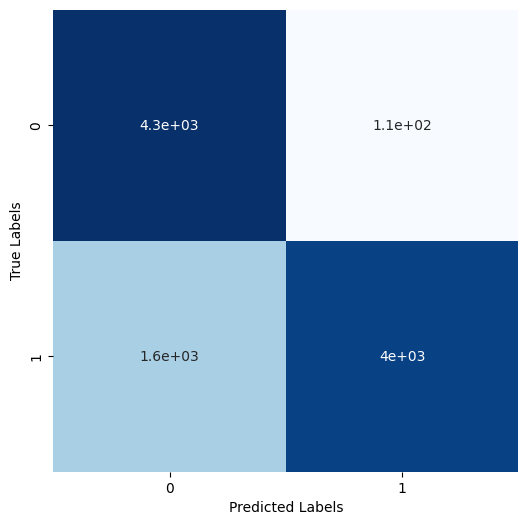

In [60]:
print(f"Evaluation du modèle : {stacked_GRU_model.evaluate(X_test, y_test)}")
y_pred = stacked_GRU_model.predict(X_test)
preds = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, preds, normalize='all')
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [62]:
stacked_GRU.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 20, 32)            448       
                                                                 
 dropout_11 (Dropout)        (None, 20, 32)            0         
                                                                 
 batch_normalization_8 (Batc  (None, 20, 32)           128       
 hNormalization)                                                 
                                                                 
 gru_6 (GRU)                 (None, 20, 256)           222720    
                                                                 
 gru_7 (GRU)                 (None, 20, 256)           394752    
                                                                 
 gru_8 (GRU)                 (None, 256)               394752    
                                                      

## Simple GRU

In [16]:
simple_GRU_model = simple_GRU(input_sequence_shape)
# simple_GRU_model.summary()


In [17]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.01)
simple_GRU_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')

In [18]:

%%time
history = simple_GRU_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.3, callbacks=[callback])

Epoch 1/10
985/985 [==============================] - 33s 31ms/step - loss: 0.7288 - accuracy: 0.5172 - val_loss: 0.7388 - val_accuracy: 0.4464
Epoch 2/10
985/985 [==============================] - 32s 32ms/step - loss: 0.6957 - accuracy: 0.5328 - val_loss: 0.7154 - val_accuracy: 0.4464
Epoch 3/10
985/985 [==============================] - 31s 31ms/step - loss: 0.6899 - accuracy: 0.5462 - val_loss: 0.7124 - val_accuracy: 0.4464
Epoch 4/10
985/985 [==============================] - 31s 32ms/step - loss: 0.6887 - accuracy: 0.5509 - val_loss: 0.6962 - val_accuracy: 0.4502
Epoch 5/10
985/985 [==============================] - 45s 45ms/step - loss: 0.6885 - accuracy: 0.5528 - val_loss: 0.7153 - val_accuracy: 0.4464
Epoch 6/10
985/985 [==============================] - 34s 35ms/step - loss: 0.6886 - accuracy: 0.5530 - val_loss: 0.7139 - val_accuracy: 0.4464
Epoch 7/10
985/985 [==============================] - 35s 36ms/step - loss: 0.6882 - accuracy: 0.5529 - val_loss: 0.7108 - val_accuracy:

313/313 [==============================] - 2s 7ms/step - loss: 0.6963 - accuracy: 0.4509
Evaluation du modèle : [0.6962619423866272, 0.45089998841285706]
313/313 [==============================] - 3s 7ms/step


Text(45.722222222222214, 0.5, 'True Labels')

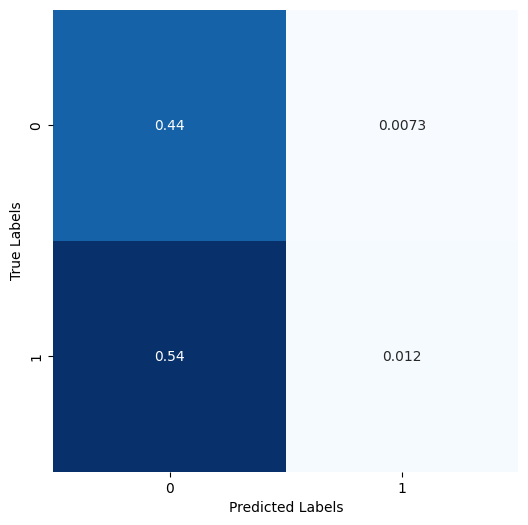

In [19]:
print(f"Evaluation du modèle : {simple_GRU_model.evaluate(X_test, y_test)}")
y_pred = simple_GRU_model.predict(X_test)
preds = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, preds, normalize='all')
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

<AxesSubplot:>

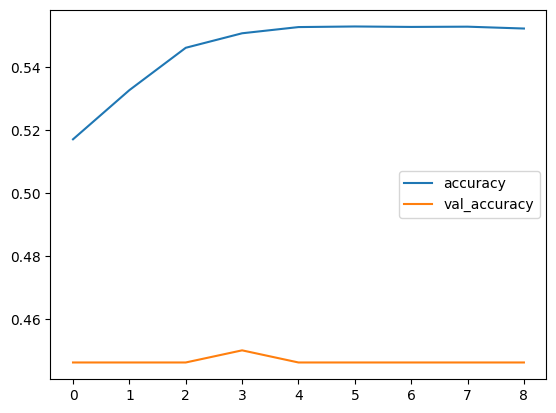

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

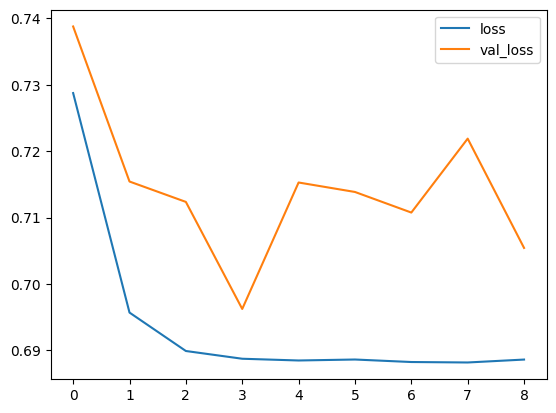

In [21]:
history_df.loc[:, ['loss', 'val_loss']].plot()

## Stacked LSTM

3-stacked LSTM, sur la base de :  [*A deep learning based misbehavior classification scheme for intrusion detection in cooperative intelligent transportation systems*](https://www.sciencedirect.com/science/article/pii/S2352864822001407) section 4.4 : Training & Testing


In [13]:
stacked_LSTM_model = stacked_LSTM(input_sequence_shape)

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
opt = keras.optimizers.Adam(learning_rate=0.0003)
stacked_LSTM_model.compile(loss='mean_absolute_error', optimizer=opt, metrics='accuracy')

In [14]:
history = stacked_LSTM_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.3, callbacks=[callback])

Epoch 1/10
4533/4533 [==============================] - 1163s 255ms/step - loss: 0.2077 - accuracy: 0.7939 - val_loss: 0.1872 - val_accuracy: 0.8174
Epoch 2/10
4533/4533 [==============================] - 1235s 272ms/step - loss: 0.1671 - accuracy: 0.8341 - val_loss: 0.1128 - val_accuracy: 0.8891
Epoch 3/10
4533/4533 [==============================] - 1048s 231ms/step - loss: 0.1075 - accuracy: 0.8937 - val_loss: 0.1071 - val_accuracy: 0.8937
Epoch 4/10
4533/4533 [==============================] - 984s 217ms/step - loss: 0.0816 - accuracy: 0.9192 - val_loss: 0.0658 - val_accuracy: 0.9348
Epoch 5/10
4533/4533 [==============================] - 1131s 249ms/step - loss: 0.0678 - accuracy: 0.9331 - val_loss: 0.0495 - val_accuracy: 0.9515
Epoch 6/10
4533/4533 [==============================] - 1124s 248ms/step - loss: 0.0601 - accuracy: 0.9406 - val_loss: 0.0509 - val_accuracy: 0.9496
Epoch 7/10
4533/4533 [==============================] - 1065s 235ms/step - loss: 0.0539 - accuracy: 0.9466 

1439/1439 [==============================] - 71s 49ms/step - loss: 0.0432 - accuracy: 0.9572
Evaluation du modèle : [0.04316072165966034, 0.9571921825408936]
1439/1439 [==============================] - 70s 48ms/step


Text(45.722222222222214, 0.5, 'True Labels')

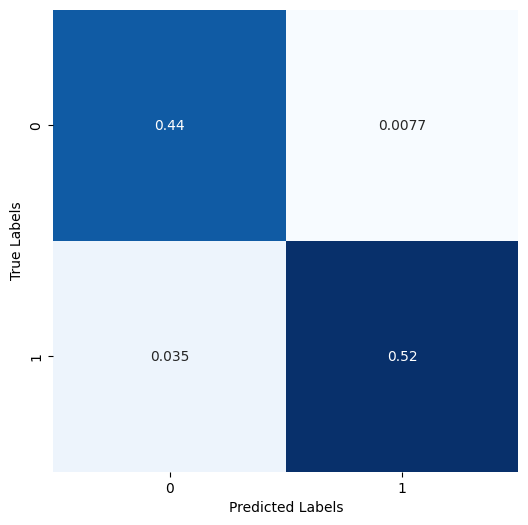

In [15]:
print(f"Evaluation du modèle : {stacked_LSTM_model.evaluate(X_test, y_test)}")
y_pred = stacked_LSTM_model.predict(X_test)
preds = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, preds, normalize='all')
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

<AxesSubplot:>

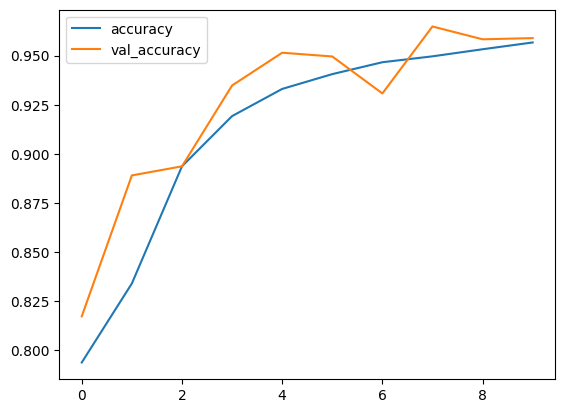

In [16]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

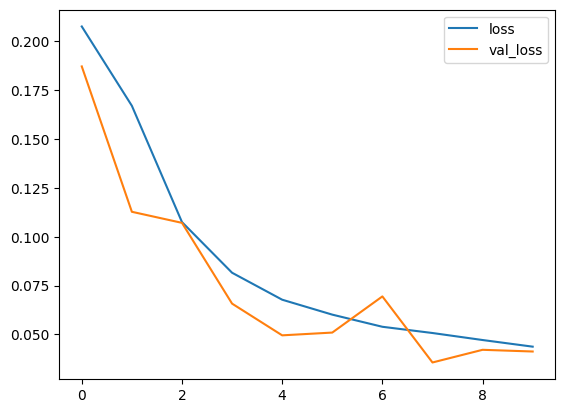

In [17]:
history_df.loc[:, ['loss', 'val_loss']].plot()